# install libraries

In [ ]:
!pip install --upgrade pip
!pip install "snowflake-connector-python[pandas]" "snowflake-snowpark-python[pandas]" snowflake-snowpark-python==1.9.0 fosforio fosforml numpy pandas matplotlib scikit-learn xgboost seaborn python-dateutil tqdm holidays faker
!pip install --upgrade --q snowflake-snowpark-python==1.9.0
!pip uninstall urllib3 -y
!pip install urllib3==1.26.15

# Import helper libraries

In [1]:
from fosforio import snowflake
from fosforml import *
from fosforml.constants import MLModelFlavours
from fosforio import get_dataframe
from matplotlib import pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import warnings; warnings.simplefilter('ignore')
from joblib import dump, load
import requests
from tqdm import tqdm
import time
import calendar

from time import sleep
import configparser
from dateutil.relativedelta import relativedelta
import datetime
from dateutil.easter import easter
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit

%matplotlib inline

Connection manager service url initialised to http://fdc-project-manager:80/project-manager
If you need to update its value then update the variable CONNECTION_MANAGER_BASE_URL in os env.


/tmp/pip_packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
Matplotlib created a temporary cache directory at /tmp/matplotlib-3rnl9xh5 because the default path (/home/mosaic-ai/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# connect to snowflake

In [2]:
snowflake.get_connection(connection_name="TTH_REV_OPT_CXN")
data = get_dataframe("BOOKINGS_TRANSFORMED")
data

Connection object created: <snowflake.connector.connection.SnowflakeConnection object at 0x7f19887ee610>
Please close the connection after use!
Reading dataframe from snowflake native connector


,ARRIVAL_DATE_TRANSFORMED,RESERVATION_STATUS_DATE_TRANSFORMED,HOTEL,IS_CANCELED,LEAD_TIME,ARRIVAL_DATE_YEAR,MONTH,ARRIVAL_DATE_WEEK_NUMBER,ARRIVAL_DATE_DAY_OF_MONTH,EXPECTED_ARRIVAL_DATE,RESERVATION_STATUS,RESERVATION_STATUS_DATE,TOTAL_STAY_NIGHTS,TALLY_DAYS,STAYS_IN_WEEKEND_NIGHTS,STAYS_IN_WEEK_NIGHTS,ADULTS,CHILDREN,BABIES,TOTAL_GUESTS,AVG_ROOMS_PER_NIGHT,TOTAL_ROOM_NIGHTS,MEAL,COUNTRY,MARKET_SEGMENT,DISTRIBUTION_CHANNEL,PREVIOUS_CANCELLATIONS,PREVIOUS_BOOKINGS_NOT_CANCELED,RESERVED_ROOM_TYPE,ASSIGNED_ROOM_TYPE,DEPOSIT_TYPE,DAYS_IN_WAITING_LIST,CUSTOMER_TYPE,ADR,BOOKING_ID,CUST_ID
0,2024-01-06,2023-07-08,City Hotel,1,182,2024,1,1,6,2024-01-06,Canceled,2023-07-08,5,0.129,1,4,2,0,0,2,1,5,BB,NLD,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,104.00,B20230802421734,C0106454
1,2023-08-27,2023-07-23,City Hotel,0,35,2023,8,34,27,2023-08-27,Check.Out,2023-07-23,3,3.000,0,3,2,0,0,2,1,3,SC,AUT,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,109.00,B20230731494526,C0106455
2,2023-08-28,2023-07-24,City Hotel,0,35,2023,8,35,28,2023-08-28,Check.Out,2023-07-24,2,2.000,0,2,2,0,0,2,1,2,BB,PRT,Direct,Direct,0,0,A,E,No Deposit,0,Transient,104.13,B20230730516400,C0106456
3,2023-08-29,2023-05-05,City Hotel,0,116,2023,8,35,29,2023-08-29,Check.Out,2023-05-05,1,1.000,0,1,2,0,0,2,1,1,BB,BRA,Online TA,TA/TO,0,0,D,D,No Deposit,0,Transient,104.40,B20230730842717,C0106457
4,2023-08-27,2023-07-21,City Hotel,0,37,2023,8,34,27,2023-08-27,Check.Out,2023-07-21,3,3.000,0,3,1,0,0,1,1,3,BB,ITA,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,119.00,B20230803534453,C0106458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109613,2023-08-29,2023-08-22,City Hotel,0,7,2023,8,35,29,2023-08-29,Check.Out,2023-08-22,1,1.000,0,1,2,0,0,2,1,1,BB,PRT,Direct,Direct,0,0,A,D,No Deposit,0,Transient,100.00,B20230729182897,C0106449
109614,2023-08-28,2023-06-03,City Hotel,0,86,2023,8,35,28,2023-08-28,Check.Out,2023-06-03,2,2.000,0,2,2,0,0,2,1,2,BB,FRA,Online TA,TA/TO,0,0,D,D,No Deposit,0,Transient,104.40,B20230725559620,C0106450
109615,2023-08-28,2023-07-15,City Hotel,0,44,2023,8,35,28,2023-08-28,Check.Out,2023-07-15,2,2.000,0,2,2,1,0,3,1,2,BB,ESP,Offline TA/TO,TA/TO,0,0,A,D,No Deposit,0,Transient,100.00,B20230725615335,C0106451
109616,2023-08-28,2023-04-04,Resort Hotel,0,146,2023,8,35,28,2023-08-28,Check.Out,2023-04-04,2,2.000,0,2,2,0,0,2,1,2,BB,PRT,Groups,Direct,0,0,D,D,No Deposit,142,Transient.Party,52.00,B20230729635233,C0106452


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109618 entries, 0 to 109617
Data columns (total 36 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ARRIVAL_DATE_TRANSFORMED             109618 non-null  object 
 1   RESERVATION_STATUS_DATE_TRANSFORMED  109618 non-null  object 
 2   HOTEL                                109618 non-null  object 
 3   IS_CANCELED                          109618 non-null  int8   
 4   LEAD_TIME                            109618 non-null  int16  
 5   ARRIVAL_DATE_YEAR                    109618 non-null  int16  
 6   MONTH                                109618 non-null  int8   
 7   ARRIVAL_DATE_WEEK_NUMBER             109618 non-null  int8   
 8   ARRIVAL_DATE_DAY_OF_MONTH            109618 non-null  int8   
 9   EXPECTED_ARRIVAL_DATE                109618 non-null  object 
 10  RESERVATION_STATUS                   109618 non-null  object 
 11  RESERVATION_S

# removing Canceletions and no-shows and keep City hotel data only


In [4]:
def update_values(row):
    if row['hotel'] == 'City Hotel' and row['reserved_room_type'] == 'A':
        return 150
    elif row['hotel'] == 'City Hotel' and row['reserved_room_type'] == 'D':
        return 80
    elif row['hotel'] == 'City Hotel' and row['reserved_room_type'] == 'E':
        return 30
    elif row['hotel'] == 'Resort Hotel' and row['reserved_room_type'] == 'A':
        return 150
    elif row['hotel'] == 'Resort Hotel' and row['reserved_room_type'] == 'D':
        return 75
    elif row['hotel'] == 'Resort Hotel' and row['reserved_room_type'] == 'E':
        return 60
    else:
        pass

In [5]:
data.columns = map(lambda x: str(x).lower(), data.columns)

In [6]:
data['room_limit'] = data.apply(update_values, axis=1)
data

,arrival_date_transformed,reservation_status_date_transformed,hotel,is_canceled,lead_time,arrival_date_year,month,arrival_date_week_number,arrival_date_day_of_month,expected_arrival_date,reservation_status,reservation_status_date,total_stay_nights,tally_days,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,total_guests,avg_rooms_per_night,total_room_nights,meal,country,market_segment,distribution_channel,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,deposit_type,days_in_waiting_list,customer_type,adr,booking_id,cust_id,room_limit
0,2024-01-06,2023-07-08,City Hotel,1,182,2024,1,1,6,2024-01-06,Canceled,2023-07-08,5,0.129,1,4,2,0,0,2,1,5,BB,NLD,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,104.00,B20230802421734,C0106454,150
1,2023-08-27,2023-07-23,City Hotel,0,35,2023,8,34,27,2023-08-27,Check.Out,2023-07-23,3,3.000,0,3,2,0,0,2,1,3,SC,AUT,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,109.00,B20230731494526,C0106455,150
2,2023-08-28,2023-07-24,City Hotel,0,35,2023,8,35,28,2023-08-28,Check.Out,2023-07-24,2,2.000,0,2,2,0,0,2,1,2,BB,PRT,Direct,Direct,0,0,A,E,No Deposit,0,Transient,104.13,B20230730516400,C0106456,150
3,2023-08-29,2023-05-05,City Hotel,0,116,2023,8,35,29,2023-08-29,Check.Out,2023-05-05,1,1.000,0,1,2,0,0,2,1,1,BB,BRA,Online TA,TA/TO,0,0,D,D,No Deposit,0,Transient,104.40,B20230730842717,C0106457,80
4,2023-08-27,2023-07-21,City Hotel,0,37,2023,8,34,27,2023-08-27,Check.Out,2023-07-21,3,3.000,0,3,1,0,0,1,1,3,BB,ITA,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,119.00,B20230803534453,C0106458,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109613,2023-08-29,2023-08-22,City Hotel,0,7,2023,8,35,29,2023-08-29,Check.Out,2023-08-22,1,1.000,0,1,2,0,0,2,1,1,BB,PRT,Direct,Direct,0,0,A,D,No Deposit,0,Transient,100.00,B20230729182897,C0106449,150
109614,2023-08-28,2023-06-03,City Hotel,0,86,2023,8,35,28,2023-08-28,Check.Out,2023-06-03,2,2.000,0,2,2,0,0,2,1,2,BB,FRA,Online TA,TA/TO,0,0,D,D,No Deposit,0,Transient,104.40,B20230725559620,C0106450,80
109615,2023-08-28,2023-07-15,City Hotel,0,44,2023,8,35,28,2023-08-28,Check.Out,2023-07-15,2,2.000,0,2,2,1,0,3,1,2,BB,ESP,Offline TA/TO,TA/TO,0,0,A,D,No Deposit,0,Transient,100.00,B20230725615335,C0106451,150
109616,2023-08-28,2023-04-04,Resort Hotel,0,146,2023,8,35,28,2023-08-28,Check.Out,2023-04-04,2,2.000,0,2,2,0,0,2,1,2,BB,PRT,Groups,Direct,0,0,D,D,No Deposit,142,Transient.Party,52.00,B20230729635233,C0106452,75


In [7]:
data.columns

Index(['arrival_date_transformed', 'reservation_status_date_transformed',
       'hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'expected_arrival_date', 'reservation_status',
       'reservation_status_date', 'total_stay_nights', 'tally_days',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'total_guests', 'avg_rooms_per_night', 'total_room_nights',
       'meal', 'country', 'market_segment', 'distribution_channel',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr', 'booking_id', 'cust_id',
       'room_limit'],
      dtype='object')

In [8]:
df = data[(data['is_canceled'] == 0) & (data['reservation_status'] !='No-Show')] 
df

,arrival_date_transformed,reservation_status_date_transformed,hotel,is_canceled,lead_time,arrival_date_year,month,arrival_date_week_number,arrival_date_day_of_month,expected_arrival_date,reservation_status,reservation_status_date,total_stay_nights,tally_days,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,total_guests,avg_rooms_per_night,total_room_nights,meal,country,market_segment,distribution_channel,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,deposit_type,days_in_waiting_list,customer_type,adr,booking_id,cust_id,room_limit
1,2023-08-27,2023-07-23,City Hotel,0,35,2023,8,34,27,2023-08-27,Check.Out,2023-07-23,3,3.0,0,3,2,0,0,2,1,3,SC,AUT,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,109.00,B20230731494526,C0106455,150
2,2023-08-28,2023-07-24,City Hotel,0,35,2023,8,35,28,2023-08-28,Check.Out,2023-07-24,2,2.0,0,2,2,0,0,2,1,2,BB,PRT,Direct,Direct,0,0,A,E,No Deposit,0,Transient,104.13,B20230730516400,C0106456,150
3,2023-08-29,2023-05-05,City Hotel,0,116,2023,8,35,29,2023-08-29,Check.Out,2023-05-05,1,1.0,0,1,2,0,0,2,1,1,BB,BRA,Online TA,TA/TO,0,0,D,D,No Deposit,0,Transient,104.40,B20230730842717,C0106457,80
4,2023-08-27,2023-07-21,City Hotel,0,37,2023,8,34,27,2023-08-27,Check.Out,2023-07-21,3,3.0,0,3,1,0,0,1,1,3,BB,ITA,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,119.00,B20230803534453,C0106458,150
5,2023-08-26,2023-03-01,City Hotel,0,178,2023,8,34,26,2023-08-26,Check.Out,2023-03-01,4,4.0,0,4,2,0,0,2,1,4,BB,DEU,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,90.90,B20230728340318,C0106459,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109613,2023-08-29,2023-08-22,City Hotel,0,7,2023,8,35,29,2023-08-29,Check.Out,2023-08-22,1,1.0,0,1,2,0,0,2,1,1,BB,PRT,Direct,Direct,0,0,A,D,No Deposit,0,Transient,100.00,B20230729182897,C0106449,150
109614,2023-08-28,2023-06-03,City Hotel,0,86,2023,8,35,28,2023-08-28,Check.Out,2023-06-03,2,2.0,0,2,2,0,0,2,1,2,BB,FRA,Online TA,TA/TO,0,0,D,D,No Deposit,0,Transient,104.40,B20230725559620,C0106450,80
109615,2023-08-28,2023-07-15,City Hotel,0,44,2023,8,35,28,2023-08-28,Check.Out,2023-07-15,2,2.0,0,2,2,1,0,3,1,2,BB,ESP,Offline TA/TO,TA/TO,0,0,A,D,No Deposit,0,Transient,100.00,B20230725615335,C0106451,150
109616,2023-08-28,2023-04-04,Resort Hotel,0,146,2023,8,35,28,2023-08-28,Check.Out,2023-04-04,2,2.0,0,2,2,0,0,2,1,2,BB,PRT,Groups,Direct,0,0,D,D,No Deposit,142,Transient.Party,52.00,B20230729635233,C0106452,75


In [9]:
df.groupby(['hotel','market_segment','reserved_room_type']).agg({'adr':'mean','reservation_status_date_transformed':'count'})


adr  \
hotel        market_segment reserved_room_type               
City Hotel   Aviation       A                    96.503608   
                            D                   107.713951   
                            E                   159.250000   
             Complementary  A                    47.880952   
                            D                    25.000000   
                            E                    55.000000   
             Corporate      A                    80.089309   
                            D                   100.689130   
                            E                   114.887931   
             Direct         A                   107.774828   
                            D                   132.383522   
                            E                   164.454444   
             Groups         A                    86.892940   
                            D                    87.340441   
                            E                    80.000000   
             Offline TA/TO  A                    91.290955   
                            D                    90.301959   
                            E                   133.251806   
             Online TA      A                   106.484167   
                            D                   136.505057   
                            E                   169.355059   
Resort Hotel Complementary  A                    21.226923   
                            D                    41.216667   
                            E                     7.333333   
             Corporate      A                    49.728996   
                            D                    67.398478   
                            E                    61.588545   
             Direct         A                    84.626374   
                            D                   116.982329   
                            E                   118.980300   
             Groups         A                    67.339807   
                            D                    74.881529   
                            E                    87.092028   
             Offline TA/TO  A                    64.276926   
                            D                    85.328087   
                            E                    97.511393   
             Online TA      A                    90.930109   
                            D                   113.303901   
                            E                   117.994331   

                                                reservation_status_date_transformed  
hotel        market_segment reserved_room_type                                       
City Hotel   Aviation       A                                                    97  
                            D                                                    81  
                            E                                                     2  
             Complementary  A                                                    21  
                            D                                                     4  
                            E                                                     2  
             Corporate      A                                                  2069  
                            D                                                   138  
                            E                                                    87  
             Direct         A                                                  3144  
                            D                                                   900  
                            E                                                   405  
             Groups         A                                                  4132  
                            D                                                    68  
                            E                                                     2  
             Offline TA/TO  A                     

In [10]:
data = df[(df.market_segment != 'Complementary') ]
data = data[(data.reserved_room_type == 'A') |(data.reserved_room_type == 'D') | (data.reserved_room_type == 'E')]
data.reserved_room_type.value_counts()


reserved_room_type
A    50832
D    12845
E     4483
Name: count, dtype: int64

In [15]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 68160 entries, 1 to 109617
Data columns (total 38 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   arrival_date_transformed             68160 non-null  object 
 1   reservation_status_date_transformed  68160 non-null  object 
 2   hotel                                68160 non-null  object 
 3   is_canceled                          68160 non-null  int8   
 4   lead_time                            68160 non-null  int16  
 5   arrival_date_year                    68160 non-null  int16  
 6   month                                68160 non-null  int8   
 7   arrival_date_week_number             68160 non-null  int8   
 8   arrival_date_day_of_month            68160 non-null  int8   
 9   expected_arrival_date                68160 non-null  object 
 10  reservation_status                   68160 non-null  object 
 11  reservation_status_date         

In [16]:
data_backup = data.copy()

In [17]:
hotels = data['hotel'].unique()
room_types = data['reserved_room_type'].unique()

In [18]:
data['total_rns'] = data['stays_in_week_nights'] + data['stays_in_weekend_nights']
data_to_transform = data[['hotel','reserved_room_type','arrival_date_transformed','total_rns','adr', 'room_limit']]
data_to_transform

,hotel,reserved_room_type,arrival_date_transformed,total_rns,adr,room_limit
1,City Hotel,A,2023-08-27,3,109.00,150
2,City Hotel,A,2023-08-28,2,104.13,150
3,City Hotel,D,2023-08-29,1,104.40,80
4,City Hotel,A,2023-08-27,3,119.00,150
5,City Hotel,A,2023-08-26,4,90.90,150
...,...,...,...,...,...,...
109613,City Hotel,A,2023-08-29,1,100.00,150
109614,City Hotel,D,2023-08-28,2,104.40,80
109615,City Hotel,A,2023-08-28,2,100.00,150
109616,Resort Hotel,D,2023-08-28,2,52.00,75


In [19]:
import os
from snowflake.snowpark.session import Session
user = os.getenv("user")
warehouse = os.getenv("warehouse")
schema= os.getenv("schema")
database = os.getenv("database")
role =  os.getenv("role")
account =  os.getenv("account")
password= os.getenv("password")

connection_params = dict(user=user, 
                         password=password, 
                         account=account, 
                         warehouse=warehouse, 
                         database=database,
                         schema=schema, 
                         role=role)

session = Session.builder.configs(connection_params).create()

session.sql('use warehouse {};'.format(warehouse)).collect()

session.sql('use database {};'.format(database)).collect()

session.sql('use schema {}.{};'.format(database, schema)).collect()

[Row(status='Statement executed successfully.')]

# Create a new dataframe to store the data by stay date

In [20]:
expanded_df = pd.DataFrame()

for _, row in data.iterrows():
    num_stay_dates = row['total_rns']
    try:
        # Create a row for each stay date
        expanded_booking = pd.DataFrame({
            'hotel': row['hotel'],
            'room_type': row['reserved_room_type'], 
            'arrival_date': pd.date_range(start=row['expected_arrival_date'], periods=num_stay_dates),
            'total_rns': 1,
            'adr': row['adr'],
            'room_limit': row['room_limit']
        })
        
        # Append the stay date information to the new dataframe
        expanded_df = pd.concat([expanded_df, expanded_booking], ignore_index=True)
    except ValueError as e:
        print(f"Error processing booking for {row['hotel']} on {row['expected_arrival_date']} : {num_stay_dates} {e}")

# Sort the final dataframe by date

In [21]:
expanded_df = expanded_df.sort_values('arrival_date')
expanded_df = expanded_df.reset_index(drop=True)
expanded_df

,hotel,room_type,arrival_date,total_rns,adr,room_limit
0,City Hotel,A,2022-05-01,1,80.00,150
1,City Hotel,A,2022-05-01,1,101.50,150
2,Resort Hotel,A,2022-05-01,1,94.00,150
3,City Hotel,A,2022-05-01,1,80.00,150
4,City Hotel,A,2022-05-01,1,80.00,150
...,...,...,...,...,...,...
232598,Resort Hotel,A,2024-07-11,1,99.06,150
232599,Resort Hotel,D,2024-07-12,1,112.80,75
232600,Resort Hotel,A,2024-07-12,1,99.06,150
232601,Resort Hotel,D,2024-07-13,1,112.80,75


In [22]:
expanded_df['adr']= np.round(expanded_df['adr'], 2)

expanded_df


,hotel,room_type,arrival_date,total_rns,adr,room_limit
0,City Hotel,A,2022-05-01,1,80.00,150
1,City Hotel,A,2022-05-01,1,101.50,150
2,Resort Hotel,A,2022-05-01,1,94.00,150
3,City Hotel,A,2022-05-01,1,80.00,150
4,City Hotel,A,2022-05-01,1,80.00,150
...,...,...,...,...,...,...
232598,Resort Hotel,A,2024-07-11,1,99.06,150
232599,Resort Hotel,D,2024-07-12,1,112.80,75
232600,Resort Hotel,A,2024-07-12,1,99.06,150
232601,Resort Hotel,D,2024-07-13,1,112.80,75


In [23]:
##check
expanded_df.head()

,hotel,room_type,arrival_date,total_rns,adr,room_limit
0,City Hotel,A,2022-05-01,1,80.0,150
1,City Hotel,A,2022-05-01,1,101.5,150
2,Resort Hotel,A,2022-05-01,1,94.0,150
3,City Hotel,A,2022-05-01,1,80.0,150
4,City Hotel,A,2022-05-01,1,80.0,150


In [24]:
# Add dow, month to data
expanded_df['dow'] = expanded_df.arrival_date.dt.strftime('%A')
expanded_df['month'] = expanded_df.arrival_date.dt.strftime('%B')

In [25]:
##check
expanded_df.head()

,hotel,room_type,arrival_date,total_rns,adr,room_limit,dow,month
0,City Hotel,A,2022-05-01,1,80.0,150,Sunday,May
1,City Hotel,A,2022-05-01,1,101.5,150,Sunday,May
2,Resort Hotel,A,2022-05-01,1,94.0,150,Sunday,May
3,City Hotel,A,2022-05-01,1,80.0,150,Sunday,May
4,City Hotel,A,2022-05-01,1,80.0,150,Sunday,May


In [26]:
expanded_df.shape

(232603, 8)

In [27]:
expanded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232603 entries, 0 to 232602
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   hotel         232603 non-null  object        
 1   room_type     232603 non-null  object        
 2   arrival_date  232603 non-null  datetime64[ns]
 3   total_rns     232603 non-null  int64         
 4   adr           232603 non-null  float64       
 5   room_limit    232603 non-null  int64         
 6   dow           232603 non-null  object        
 7   month         232603 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 14.2+ MB


In [28]:
daily_rns= expanded_df.groupby(['arrival_date','dow','month', 'hotel', 'room_type']).agg({'room_limit': 'mean', 'total_rns':'sum'}).reset_index() # ge total stays per day

daily_rns = daily_rns.groupby(['dow','month', 'hotel', 'room_type']).agg({'room_limit': 'mean','total_rns':['sum','mean','median']}).reset_index() # get Rns metrics by Dow & Month

daily_rns.columns = ['_'.join(col) for col in daily_rns.columns] #remove multi level column
daily_rns

,dow_,month_,hotel_,room_type_,room_limit_mean,total_rns_sum,total_rns_mean,total_rns_median
0,Friday,April,City Hotel,A,150.0,1163,145.375000,145.0
1,Friday,April,City Hotel,D,80.0,355,44.375000,46.5
2,Friday,April,City Hotel,E,30.0,37,4.625000,5.0
3,Friday,April,Resort Hotel,A,150.0,622,77.750000,78.5
4,Friday,April,Resort Hotel,D,75.0,427,53.375000,55.5
...,...,...,...,...,...,...,...,...
499,Wednesday,September,City Hotel,D,80.0,163,20.375000,20.5
500,Wednesday,September,City Hotel,E,30.0,8,1.333333,1.0
501,Wednesday,September,Resort Hotel,A,150.0,703,87.875000,89.0
502,Wednesday,September,Resort Hotel,D,75.0,142,17.750000,17.5


In [29]:
adr_frequency = expanded_df.groupby(['dow','month','adr', 'hotel', 'room_type']).agg({'room_limit': 'mean','total_rns':'sum'})
adr_frequency.reset_index(inplace=True)

In [30]:
adr_frequency

,dow,month,adr,hotel,room_type,room_limit,total_rns
0,Friday,April,6.00,City Hotel,A,150.0,1
1,Friday,April,8.00,Resort Hotel,A,150.0,1
2,Friday,April,12.00,City Hotel,A,150.0,1
3,Friday,April,45.90,Resort Hotel,A,150.0,1
4,Friday,April,47.90,Resort Hotel,A,150.0,3
...,...,...,...,...,...,...,...
92024,Wednesday,September,169.60,City Hotel,A,150.0,1
92025,Wednesday,September,170.00,City Hotel,E,30.0,1
92026,Wednesday,September,174.90,City Hotel,D,80.0,1
92027,Wednesday,September,180.25,City Hotel,A,150.0,2


In [31]:
merged_df = pd.merge(adr_frequency, daily_rns,how='left',left_on=['dow','month', 'hotel', 'room_type'], right_on=['dow_','month_', 'hotel_', 'room_type_'],suffixes=('_act', '_tot'))

merged_df = merged_df.drop(['dow_','month_'],axis=1)

merged_df

,dow,month,adr,hotel,room_type,room_limit,total_rns,hotel_,room_type_,room_limit_mean,total_rns_sum,total_rns_mean,total_rns_median
0,Friday,April,6.00,City Hotel,A,150.0,1,City Hotel,A,150.0,1163,145.375000,145.0
1,Friday,April,8.00,Resort Hotel,A,150.0,1,Resort Hotel,A,150.0,622,77.750000,78.5
2,Friday,April,12.00,City Hotel,A,150.0,1,City Hotel,A,150.0,1163,145.375000,145.0
3,Friday,April,45.90,Resort Hotel,A,150.0,1,Resort Hotel,A,150.0,622,77.750000,78.5
4,Friday,April,47.90,Resort Hotel,A,150.0,3,Resort Hotel,A,150.0,622,77.750000,78.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92024,Wednesday,September,169.60,City Hotel,A,150.0,1,City Hotel,A,150.0,772,96.500000,96.5
92025,Wednesday,September,170.00,City Hotel,E,30.0,1,City Hotel,E,30.0,8,1.333333,1.0
92026,Wednesday,September,174.90,City Hotel,D,80.0,1,City Hotel,D,80.0,163,20.375000,20.5
92027,Wednesday,September,180.25,City Hotel,A,150.0,2,City Hotel,A,150.0,772,96.500000,96.5


In [32]:
merged_df['probability'] = merged_df['total_rns']/merged_df['total_rns_sum']

In [33]:
merged_df['expected_rns'] = merged_df['probability'] * merged_df['total_rns_median']

In [34]:
merged_df = merged_df.sort_values(by=['dow', 'month', 'adr'], ascending=[True, True, False])

In [35]:
merged_df['expected_demand']=merged_df.groupby(['dow', 'month'])['expected_rns'].cumsum()

In [36]:
merged_df['expected_rev'] = merged_df['adr']* merged_df['expected_demand']

In [37]:
merged_df['expected_rev'] = merged_df['adr']* merged_df['expected_demand']

<Axes: xlabel='adr'>

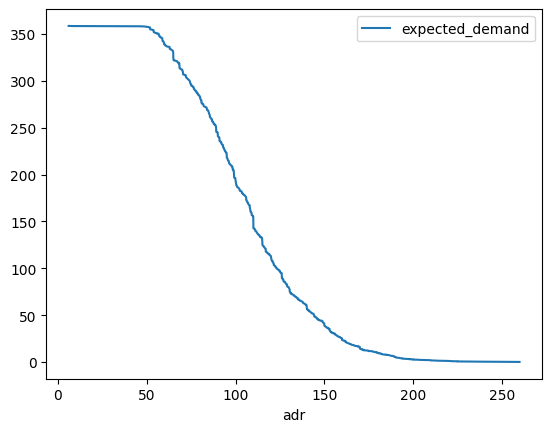

In [38]:
merged_df[(merged_df.dow == 'Friday') & (merged_df.month =='April')].plot(x='adr', y='expected_demand', kind='line')

<Axes: xlabel='adr'>

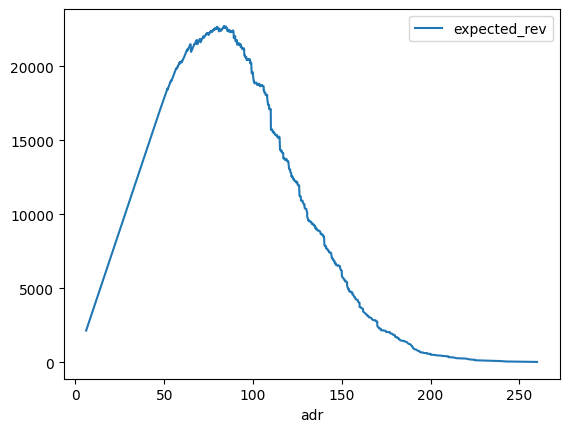

In [39]:
merged_df[(merged_df.dow == 'Friday') & (merged_df.month =='April')].plot(x='adr', y='expected_rev', kind='line')

In [40]:
merged_df

,dow,month,adr,hotel,room_type,room_limit,total_rns,hotel_,room_type_,room_limit_mean,total_rns_sum,total_rns_mean,total_rns_median,probability,expected_rns,expected_demand,expected_rev
1122,Friday,April,260.00,City Hotel,E,30.0,1,City Hotel,E,30.0,37,4.625,5.0,0.027027,0.135135,0.135135,35.135135
1121,Friday,April,243.00,Resort Hotel,A,150.0,1,Resort Hotel,A,150.0,622,77.750,78.5,0.001608,0.126206,0.261341,63.505844
1120,Friday,April,239.00,City Hotel,E,30.0,1,City Hotel,E,30.0,37,4.625,5.0,0.027027,0.135135,0.396476,94.757778
1119,Friday,April,231.00,City Hotel,E,30.0,1,City Hotel,E,30.0,37,4.625,5.0,0.027027,0.135135,0.531611,122.802186
1117,Friday,April,225.00,City Hotel,A,150.0,1,City Hotel,A,150.0,1163,145.375,145.0,0.000860,0.124678,0.656289,147.664969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91319,Wednesday,September,19.35,Resort Hotel,A,150.0,2,Resort Hotel,A,150.0,703,87.875,89.0,0.002845,0.253201,241.368599,4670.482388
91318,Wednesday,September,18.50,Resort Hotel,A,150.0,2,Resort Hotel,A,150.0,703,87.875,89.0,0.002845,0.253201,241.621799,4470.003289
91317,Wednesday,September,13.00,Resort Hotel,A,150.0,1,Resort Hotel,A,150.0,703,87.875,89.0,0.001422,0.126600,241.748400,3142.729196
91316,Wednesday,September,12.00,City Hotel,A,150.0,1,City Hotel,A,150.0,772,96.500,96.5,0.001295,0.125000,241.873400,2902.480797


In [41]:
from scipy.optimize import curve_fit

# Define the demand curve function
def demand_curve(x, a, b, c, d, max_demand):
    demand = a * np.exp(-b * x) + c
    demand = np.where(x <= max_demand, np.minimum(demand, max_demand), demand)
    return demand + d


In [42]:
x_data = merged_df['adr'].values
y_data = merged_df['expected_demand'].values


initial_guess = [1, 0.01, 1, 1, 100]
bounds = ([0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])

params, _ = curve_fit(demand_curve, x_data, y_data, bounds=bounds, p0=initial_guess)

a_fit, b_fit, c_fit ,d_fit,max_demand= params

In [43]:
predicted_demand = demand_curve(x_data, a_fit, b_fit,c_fit,d_fit,max_demand)

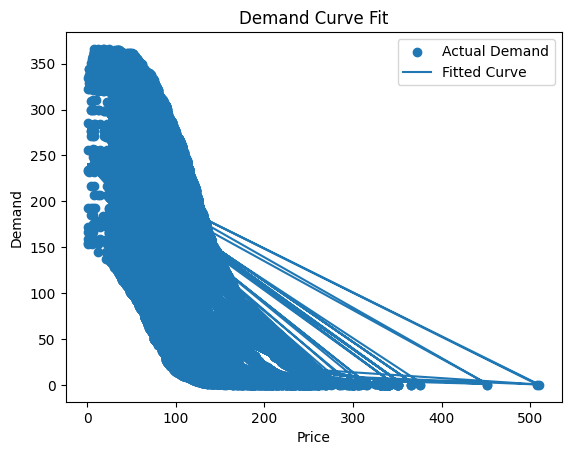

In [44]:
plt.scatter(x_data, y_data, label='Actual Demand')
plt.plot(x_data, predicted_demand, label='Fitted Curve')
plt.xlabel('Price')
plt.ylabel('Demand')
plt.legend()
plt.title('Demand Curve Fit')
plt.show()

In [45]:
def revenue(price):
    return price * demand_curve(price, a_fit, b_fit,c_fit,d_fit,max_demand)

In [46]:
objective = lambda price: -revenue(price)
from scipy.optimize import minimize_scalar

result = minimize_scalar(objective, bounds=(60, 180), method='bounded')
optimal_price = result.x
max_revenue = -result.fun
room_sold = demand_curve(optimal_price, a_fit, b_fit,c_fit,d_fit,max_demand)

In [47]:
print(f"The optimal price to maximize revenue: ${optimal_price}")
print(f"The maximum revenue achievable: ${max_revenue}")
print(f"The expected number of rooms to sell: {room_sold}")

The optimal price to maximize revenue: $72.49069868973314
The maximum revenue achievable: $14611.505931969143
The expected number of rooms to sell: 201.56387227701768


In [48]:
from scipy.optimize import brentq

def demand_to_price(num_rooms, a, b, c, d, max_demand):
    def root_func(x):
        return num_rooms - (a * np.exp(-b * x) + c)

    try:
        price = brentq(root_func, 0, 200)  # Adjust the interval bounds as needed
    except ValueError:
        # Fallback to default price if no root is found
        price_range=(0, 200)
        price = np.random.uniform(*price_range)

    return price

# from scipy.optimize import brentq

# def demand_to_price(num_rooms, a, b, c, d, max_demand):
   
#     def root_func(x):
#         return num_rooms - (a * np.exp(-b * x) + c)
    
#     # Find the price using numerical root finding
#     price = brentq(root_func, 0, 200)  # Adjust the interval bounds as needed
    
#     return price

In [49]:
demand_to_price(50,a_fit,b_fit,c_fit,d_fit,max_demand)

173.5487742376483

In [50]:
results = pd.DataFrame(columns=['month', 'hotel','room_limit', 'room_type', 'dow', 'optimal_rate', 'expected_rn','expected_rev','optimal_rate_lim_inv'])

In [51]:
months = merged_df.month.unique()
dow = merged_df.dow.unique()

In [52]:
merged_df

,dow,month,adr,hotel,room_type,room_limit,total_rns,hotel_,room_type_,room_limit_mean,total_rns_sum,total_rns_mean,total_rns_median,probability,expected_rns,expected_demand,expected_rev
1122,Friday,April,260.00,City Hotel,E,30.0,1,City Hotel,E,30.0,37,4.625,5.0,0.027027,0.135135,0.135135,35.135135
1121,Friday,April,243.00,Resort Hotel,A,150.0,1,Resort Hotel,A,150.0,622,77.750,78.5,0.001608,0.126206,0.261341,63.505844
1120,Friday,April,239.00,City Hotel,E,30.0,1,City Hotel,E,30.0,37,4.625,5.0,0.027027,0.135135,0.396476,94.757778
1119,Friday,April,231.00,City Hotel,E,30.0,1,City Hotel,E,30.0,37,4.625,5.0,0.027027,0.135135,0.531611,122.802186
1117,Friday,April,225.00,City Hotel,A,150.0,1,City Hotel,A,150.0,1163,145.375,145.0,0.000860,0.124678,0.656289,147.664969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91319,Wednesday,September,19.35,Resort Hotel,A,150.0,2,Resort Hotel,A,150.0,703,87.875,89.0,0.002845,0.253201,241.368599,4670.482388
91318,Wednesday,September,18.50,Resort Hotel,A,150.0,2,Resort Hotel,A,150.0,703,87.875,89.0,0.002845,0.253201,241.621799,4470.003289
91317,Wednesday,September,13.00,Resort Hotel,A,150.0,1,Resort Hotel,A,150.0,703,87.875,89.0,0.001422,0.126600,241.748400,3142.729196
91316,Wednesday,September,12.00,City Hotel,A,150.0,1,City Hotel,A,150.0,772,96.500,96.5,0.001295,0.125000,241.873400,2902.480797


In [53]:
for hotel in hotels:
    for room_type in room_types:
        for month in months:
            for day in dow:
                # Get data for the specific combination
                data_subset = merged_df[(merged_df['dow'] == day) & 
                                        (merged_df['hotel'] == hotel) & 
                                        (merged_df['room_type'] == room_type) & 
                                        (merged_df['month'] == month)].reset_index()
                
                if data_subset.empty:
                    continue

                # Remove outliers
                mean = data_subset['adr'].mean()
                std_dev = data_subset['adr'].std()
                data_subset['z_scores'] = np.abs((data_subset['adr'] - mean) / std_dev)
                data_subset = data_subset[data_subset['z_scores'] <= 2]

                # Fit demand curve
                x_data = data_subset['adr'].values
                y_data = data_subset['expected_demand'].values

                try:
                    initial_guess = [1, 0.01, 1, 1, data_subset['total_rns_median'].values[0]]
                    bounds = ([0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])
                    maxfev = 10000  # Increase the number of maximum function evaluations
                    params, _ = curve_fit(demand_curve, x_data, y_data, bounds=bounds, p0=initial_guess, maxfev=maxfev)
                except RuntimeError as e:
                    print(f"Error fitting demand curve for {hotel}, {room_type}, {month}, {day}: {e}")
                    continue

                a_fit, b_fit, c_fit, d_fit, max_demand = params

                # Optimize revenue
                def revenue(price):
                    return price * demand_curve(price, a_fit, b_fit, c_fit, d_fit, max_demand)

                objective = lambda price: -revenue(price)
                optimize = minimize_scalar(objective, bounds=(45, 200), method='bounded')
                optimal_price = optimize.x
                max_revenue = -optimize.fun
                expected_rns = demand_curve(optimal_price, a_fit, b_fit, c_fit, d_fit, max_demand)

                optimal_rate_lim_inv = demand_to_price(data_subset['room_limit'].mean(), a_fit, b_fit, c_fit, d_fit, max_demand)

                new_row = pd.DataFrame({'hotel': hotel,
                                        'room_type': room_type,
                                        'room_limit': data_subset['room_limit'].mean(),
                                        'month': month,
                                        'dow': day,
                                        'optimal_rate': optimal_price,
                                        'expected_rev': max_revenue,
                                        'expected_rn': expected_rns,
                                        'optimal_rate_lim_inv': optimal_rate_lim_inv}, index=[0])
                results = pd.concat([results, new_row], ignore_index=True)


Error fitting demand curve for City Hotel, E, September, Saturday: Optimal parameters not found: The maximum number of function evaluations is exceeded.


In [54]:
results

,month,hotel,room_limit,room_type,dow,optimal_rate,expected_rn,expected_rev,optimal_rate_lim_inv
0,April,City Hotel,150.0,A,Friday,83.180013,297.440357,24741.092735,108.566578
1,April,City Hotel,150.0,A,Monday,83.667252,300.493621,25141.475498,112.058844
2,April,City Hotel,150.0,A,Saturday,82.783771,293.388216,24287.782987,107.362122
3,April,City Hotel,150.0,A,Sunday,81.700537,308.815326,25230.377930,110.117610
4,April,City Hotel,150.0,A,Thursday,83.738717,288.282494,24140.406020,107.964966
...,...,...,...,...,...,...,...,...,...
498,September,Resort Hotel,60.0,E,Saturday,47.316444,215.696017,10205.968483,107.859042
499,September,Resort Hotel,60.0,E,Sunday,45.000008,221.384433,9962.301161,97.937742
500,September,Resort Hotel,60.0,E,Thursday,45.000008,134.794610,6065.758477,75.488623
501,September,Resort Hotel,60.0,E,Tuesday,45.000008,248.628444,11188.281860,104.359658


In [55]:
#clean up the results
results['optimal_rate'] = results['optimal_rate'].round()
results['optimal_rate_lim_inv'] = results['optimal_rate_lim_inv'].round()

results['expected_rn'] = results['expected_rn'].round().astype(int)
results['expected_rev'] = results['expected_rev'].round()
results

,month,hotel,room_limit,room_type,dow,optimal_rate,expected_rn,expected_rev,optimal_rate_lim_inv
0,April,City Hotel,150.0,A,Friday,83.0,297,24741.0,109.0
1,April,City Hotel,150.0,A,Monday,84.0,300,25141.0,112.0
2,April,City Hotel,150.0,A,Saturday,83.0,293,24288.0,107.0
3,April,City Hotel,150.0,A,Sunday,82.0,309,25230.0,110.0
4,April,City Hotel,150.0,A,Thursday,84.0,288,24140.0,108.0
...,...,...,...,...,...,...,...,...,...
498,September,Resort Hotel,60.0,E,Saturday,47.0,216,10206.0,108.0
499,September,Resort Hotel,60.0,E,Sunday,45.0,221,9962.0,98.0
500,September,Resort Hotel,60.0,E,Thursday,45.0,135,6066.0,75.0
501,September,Resort Hotel,60.0,E,Tuesday,45.0,249,11188.0,104.0


In [56]:
results

,month,hotel,room_limit,room_type,dow,optimal_rate,expected_rn,expected_rev,optimal_rate_lim_inv
0,April,City Hotel,150.0,A,Friday,83.0,297,24741.0,109.0
1,April,City Hotel,150.0,A,Monday,84.0,300,25141.0,112.0
2,April,City Hotel,150.0,A,Saturday,83.0,293,24288.0,107.0
3,April,City Hotel,150.0,A,Sunday,82.0,309,25230.0,110.0
4,April,City Hotel,150.0,A,Thursday,84.0,288,24140.0,108.0
...,...,...,...,...,...,...,...,...,...
498,September,Resort Hotel,60.0,E,Saturday,47.0,216,10206.0,108.0
499,September,Resort Hotel,60.0,E,Sunday,45.0,221,9962.0,98.0
500,September,Resort Hotel,60.0,E,Thursday,45.0,135,6066.0,75.0
501,September,Resort Hotel,60.0,E,Tuesday,45.0,249,11188.0,104.0


In [57]:
results[(results['month'] == 'April') & (results['room_type'] == 'A')]

,month,hotel,room_limit,room_type,dow,optimal_rate,expected_rn,expected_rev,optimal_rate_lim_inv
0,April,City Hotel,150.0,A,Friday,83.0,297,24741.0,109.0
1,April,City Hotel,150.0,A,Monday,84.0,300,25141.0,112.0
2,April,City Hotel,150.0,A,Saturday,83.0,293,24288.0,107.0
3,April,City Hotel,150.0,A,Sunday,82.0,309,25230.0,110.0
4,April,City Hotel,150.0,A,Thursday,84.0,288,24140.0,108.0
5,April,City Hotel,150.0,A,Tuesday,83.0,301,25017.0,112.0
6,April,City Hotel,150.0,A,Wednesday,80.0,280,22417.0,106.0
251,April,Resort Hotel,150.0,A,Friday,200.0,148,29637.0,48.0
252,April,Resort Hotel,150.0,A,Monday,200.0,196,39227.0,47.0
253,April,Resort Hotel,150.0,A,Saturday,200.0,153,30529.0,48.0


In [58]:
import itertools

hotel_types = ['Resort Hotel', 'City Hotel']
room_types = ['A', 'D', 'E']

combinations = list(itertools.product(hotel_types, room_types))

combinations

combinations_df = pd.DataFrame(combinations, columns=['hotel', 'room_type'])
combinations_df

,hotel,room_type
0,Resort Hotel,A
1,Resort Hotel,D
2,Resort Hotel,E
3,City Hotel,A
4,City Hotel,D
5,City Hotel,E


In [59]:
month_dict = {month: index for index, month in enumerate(pd.date_range('2020-01-01', periods=12, freq='M').strftime('%B'), 1)}

new_data = pd.DataFrame()

start_date = pd.Timestamp('2022-05-01')
end_date = pd.Timestamp('2024-06-30')

for year in range(start_date.year, end_date.year + 1):
    for month in month_dict.values():
        if year == start_date.year and month < start_date.month:
            continue
        if year == end_date.year and month > end_date.month:
            continue
        
        month_start = pd.to_datetime(f'{year}-{month:02d}-01')
        month_end = (month_start + pd.offsets.MonthEnd(0))
        date_range = pd.date_range(month_start, month_end, freq='D')
        
        date_range = date_range[(date_range >= start_date) & (date_range <= end_date)]
        
        df = pd.DataFrame(date_range, columns=['arrival_date'])
        df['dow'] = df['arrival_date'].dt.day_name()
        df['month'] = df['arrival_date'].dt.month_name()
        result_df = df.assign(key=1).merge(combinations_df.assign(key=1), on='key').drop('key', axis=1)
        new_data = pd.concat([new_data, result_df], ignore_index=True)

new_data

,arrival_date,dow,month,hotel,room_type
0,2022-05-01,Sunday,May,Resort Hotel,A
1,2022-05-01,Sunday,May,Resort Hotel,D
2,2022-05-01,Sunday,May,Resort Hotel,E
3,2022-05-01,Sunday,May,City Hotel,A
4,2022-05-01,Sunday,May,City Hotel,D
...,...,...,...,...,...
4747,2024-06-30,Sunday,June,Resort Hotel,D
4748,2024-06-30,Sunday,June,Resort Hotel,E
4749,2024-06-30,Sunday,June,City Hotel,A
4750,2024-06-30,Sunday,June,City Hotel,D


In [60]:
final_data = pd.merge(new_data, results, how='left', on=['dow', 'hotel', 'room_type', 'month'])
final_data

,arrival_date,dow,month,hotel,room_type,room_limit,optimal_rate,expected_rn,expected_rev,optimal_rate_lim_inv
0,2022-05-01,Sunday,May,Resort Hotel,A,150.0,87.0,321.0,27982.0,122.0
1,2022-05-01,Sunday,May,Resort Hotel,D,75.0,54.0,521.0,27961.0,158.0
2,2022-05-01,Sunday,May,Resort Hotel,E,60.0,47.0,727.0,33998.0,163.0
3,2022-05-01,Sunday,May,City Hotel,A,150.0,85.0,321.0,27248.0,123.0
4,2022-05-01,Sunday,May,City Hotel,D,80.0,52.0,657.0,33811.0,152.0
...,...,...,...,...,...,...,...,...,...,...
4747,2024-06-30,Sunday,June,Resort Hotel,D,75.0,59.0,583.0,34289.0,180.0
4748,2024-06-30,Sunday,June,Resort Hotel,E,60.0,59.0,568.0,33696.0,193.0
4749,2024-06-30,Sunday,June,City Hotel,A,150.0,200.0,199.0,39735.0,68.0
4750,2024-06-30,Sunday,June,City Hotel,D,80.0,71.0,395.0,28173.0,185.0


In [61]:
final_data['room_limit'] = final_data['room_limit'].astype(int)

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [63]:
final_data['arrival_date'] = pd.to_datetime(final_data['arrival_date'])

In [64]:
final_data

,arrival_date,dow,month,hotel,room_type,room_limit,optimal_rate,expected_rn,expected_rev,optimal_rate_lim_inv
0,2022-05-01,Sunday,May,Resort Hotel,A,150.0,87.0,321.0,27982.0,122.0
1,2022-05-01,Sunday,May,Resort Hotel,D,75.0,54.0,521.0,27961.0,158.0
2,2022-05-01,Sunday,May,Resort Hotel,E,60.0,47.0,727.0,33998.0,163.0
3,2022-05-01,Sunday,May,City Hotel,A,150.0,85.0,321.0,27248.0,123.0
4,2022-05-01,Sunday,May,City Hotel,D,80.0,52.0,657.0,33811.0,152.0
...,...,...,...,...,...,...,...,...,...,...
4747,2024-06-30,Sunday,June,Resort Hotel,D,75.0,59.0,583.0,34289.0,180.0
4748,2024-06-30,Sunday,June,Resort Hotel,E,60.0,59.0,568.0,33696.0,193.0
4749,2024-06-30,Sunday,June,City Hotel,A,150.0,200.0,199.0,39735.0,68.0
4750,2024-06-30,Sunday,June,City Hotel,D,80.0,71.0,395.0,28173.0,185.0


In [65]:
final_data[final_data["optimal_rate_lim_inv"] > final_data["optimal_rate"]]

,arrival_date,dow,month,hotel,room_type,room_limit,optimal_rate,expected_rn,expected_rev,optimal_rate_lim_inv
0,2022-05-01,Sunday,May,Resort Hotel,A,150.0,87.0,321.0,27982.0,122.0
1,2022-05-01,Sunday,May,Resort Hotel,D,75.0,54.0,521.0,27961.0,158.0
2,2022-05-01,Sunday,May,Resort Hotel,E,60.0,47.0,727.0,33998.0,163.0
3,2022-05-01,Sunday,May,City Hotel,A,150.0,85.0,321.0,27248.0,123.0
4,2022-05-01,Sunday,May,City Hotel,D,80.0,52.0,657.0,33811.0,152.0
...,...,...,...,...,...,...,...,...,...,...
4745,2024-06-29,Saturday,June,City Hotel,E,30.0,60.0,563.0,33734.0,64.0
4746,2024-06-30,Sunday,June,Resort Hotel,A,150.0,99.0,296.0,29218.0,140.0
4747,2024-06-30,Sunday,June,Resort Hotel,D,75.0,59.0,583.0,34289.0,180.0
4748,2024-06-30,Sunday,June,Resort Hotel,E,60.0,59.0,568.0,33696.0,193.0


In [66]:
final_data

,arrival_date,dow,month,hotel,room_type,room_limit,optimal_rate,expected_rn,expected_rev,optimal_rate_lim_inv
0,2022-05-01,Sunday,May,Resort Hotel,A,150.0,87.0,321.0,27982.0,122.0
1,2022-05-01,Sunday,May,Resort Hotel,D,75.0,54.0,521.0,27961.0,158.0
2,2022-05-01,Sunday,May,Resort Hotel,E,60.0,47.0,727.0,33998.0,163.0
3,2022-05-01,Sunday,May,City Hotel,A,150.0,85.0,321.0,27248.0,123.0
4,2022-05-01,Sunday,May,City Hotel,D,80.0,52.0,657.0,33811.0,152.0
...,...,...,...,...,...,...,...,...,...,...
4747,2024-06-30,Sunday,June,Resort Hotel,D,75.0,59.0,583.0,34289.0,180.0
4748,2024-06-30,Sunday,June,Resort Hotel,E,60.0,59.0,568.0,33696.0,193.0
4749,2024-06-30,Sunday,June,City Hotel,A,150.0,200.0,199.0,39735.0,68.0
4750,2024-06-30,Sunday,June,City Hotel,D,80.0,71.0,395.0,28173.0,185.0


In [68]:
4110/4752

0.86489898989899

In [69]:
final_data[final_data["expected_rn"] > final_data["room_limit"]]

,arrival_date,dow,month,hotel,room_type,room_limit,optimal_rate,expected_rn,expected_rev,optimal_rate_lim_inv
0,2022-05-01,Sunday,May,Resort Hotel,A,150.0,87.0,321.0,27982.0,122.0
1,2022-05-01,Sunday,May,Resort Hotel,D,75.0,54.0,521.0,27961.0,158.0
2,2022-05-01,Sunday,May,Resort Hotel,E,60.0,47.0,727.0,33998.0,163.0
3,2022-05-01,Sunday,May,City Hotel,A,150.0,85.0,321.0,27248.0,123.0
4,2022-05-01,Sunday,May,City Hotel,D,80.0,52.0,657.0,33811.0,152.0
...,...,...,...,...,...,...,...,...,...,...
4747,2024-06-30,Sunday,June,Resort Hotel,D,75.0,59.0,583.0,34289.0,180.0
4748,2024-06-30,Sunday,June,Resort Hotel,E,60.0,59.0,568.0,33696.0,193.0
4749,2024-06-30,Sunday,June,City Hotel,A,150.0,200.0,199.0,39735.0,68.0
4750,2024-06-30,Sunday,June,City Hotel,D,80.0,71.0,395.0,28173.0,185.0


In [70]:
4417/4752

0.929503367003367

In [71]:
final_data.isna().sum()

arrival_date            0
dow                     0
month                   0
hotel                   0
room_type               0
room_limit              9
optimal_rate            9
expected_rn             9
expected_rev            9
optimal_rate_lim_inv    9
dtype: int64

In [72]:
final_data = final_data.dropna(axis=0)

In [73]:
final_data

,arrival_date,dow,month,hotel,room_type,room_limit,optimal_rate,expected_rn,expected_rev,optimal_rate_lim_inv
0,2022-05-01,Sunday,May,Resort Hotel,A,150.0,87.0,321.0,27982.0,122.0
1,2022-05-01,Sunday,May,Resort Hotel,D,75.0,54.0,521.0,27961.0,158.0
2,2022-05-01,Sunday,May,Resort Hotel,E,60.0,47.0,727.0,33998.0,163.0
3,2022-05-01,Sunday,May,City Hotel,A,150.0,85.0,321.0,27248.0,123.0
4,2022-05-01,Sunday,May,City Hotel,D,80.0,52.0,657.0,33811.0,152.0
...,...,...,...,...,...,...,...,...,...,...
4747,2024-06-30,Sunday,June,Resort Hotel,D,75.0,59.0,583.0,34289.0,180.0
4748,2024-06-30,Sunday,June,Resort Hotel,E,60.0,59.0,568.0,33696.0,193.0
4749,2024-06-30,Sunday,June,City Hotel,A,150.0,200.0,199.0,39735.0,68.0
4750,2024-06-30,Sunday,June,City Hotel,D,80.0,71.0,395.0,28173.0,185.0


In [74]:
data_backup['arrival_date_transformed'] = pd.to_datetime(data_backup['arrival_date_transformed'])
final_data['arrival_date'] = pd.to_datetime(final_data['arrival_date'])

In [75]:
rev_opt_booking = pd.merge(data_backup, final_data, right_on=['arrival_date', 'hotel', 'room_type'], left_on=['arrival_date_transformed', 'hotel', 'reserved_room_type'], how='left')
rev_opt_booking.to_csv('rev_opt_booking.csv', index=False)

In [76]:
rev_opt_booking

,arrival_date_transformed,reservation_status_date_transformed,hotel,is_canceled,lead_time,arrival_date_year,month_x,arrival_date_week_number,arrival_date_day_of_month,expected_arrival_date,reservation_status,reservation_status_date,total_stay_nights,tally_days,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,total_guests,avg_rooms_per_night,total_room_nights,meal,country,market_segment,distribution_channel,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,deposit_type,days_in_waiting_list,customer_type,adr,booking_id,cust_id,room_limit_x,total_rns,arrival_date,dow,month_y,room_type,room_limit_y,optimal_rate,expected_rn,expected_rev,optimal_rate_lim_inv
0,2023-08-27,2023-07-23,City Hotel,0,35,2023,8,34,27,2023-08-27,Check.Out,2023-07-23,3,3.0,0,3,2,0,0,2,1,3,SC,AUT,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,109.00,B20230731494526,C0106455,150,3,2023-08-27,Sunday,August,A,150.0,64.0,264.0,16788.0,83.0
1,2023-08-28,2023-07-24,City Hotel,0,35,2023,8,35,28,2023-08-28,Check.Out,2023-07-24,2,2.0,0,2,2,0,0,2,1,2,BB,PRT,Direct,Direct,0,0,A,E,No Deposit,0,Transient,104.13,B20230730516400,C0106456,150,2,2023-08-28,Monday,August,A,150.0,64.0,254.0,16189.0,81.0
2,2023-08-29,2023-05-05,City Hotel,0,116,2023,8,35,29,2023-08-29,Check.Out,2023-05-05,1,1.0,0,1,2,0,0,2,1,1,BB,BRA,Online TA,TA/TO,0,0,D,D,No Deposit,0,Transient,104.40,B20230730842717,C0106457,80,1,2023-08-29,Tuesday,August,D,80.0,45.0,489.0,22007.0,107.0
3,2023-08-27,2023-07-21,City Hotel,0,37,2023,8,34,27,2023-08-27,Check.Out,2023-07-21,3,3.0,0,3,1,0,0,1,1,3,BB,ITA,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,119.00,B20230803534453,C0106458,150,3,2023-08-27,Sunday,August,A,150.0,64.0,264.0,16788.0,83.0
4,2023-08-26,2023-03-01,City Hotel,0,178,2023,8,34,26,2023-08-26,Check.Out,2023-03-01,4,4.0,0,4,2,0,0,2,1,4,BB,DEU,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,90.90,B20230728340318,C0106459,150,4,2023-08-26,Saturday,August,A,150.0,63.0,281.0,17848.0,86.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68155,2023-08-29,2023-08-22,City Hotel,0,7,2023,8,35,29,2023-08-29,Check.Out,2023-08-22,1,1.0,0,1,2,0,0,2,1,1,BB,PRT,Direct,Direct,0,0,A,D,No Deposit,0,Transient,100.00,B20230729182897,C0106449,150,1,2023-08-29,Tuesday,August,A,150.0,67.0,264.0,17735.0,87.0
68156,2023-08-28,2023-06-03,City Hotel,0,86,2023,8,35,28,2023-08-28,Check.Out,2023-06-03,2,2.0,0,2,2,0,0,2,1,2,BB,FRA,Online TA,TA/TO,0,0,D,D,No Deposit,0,Transient,104.40,B20230725559620,C0106450,80,2,2023-08-28,Monday,August,D,80.0,45.0,450.0,20241.0,102.0
68157,2023-08-28,2023-07-15,City Hotel,0,44,2023,8,35,28,2023-08-28,Check.Out,2023-07-15,2,2.0,0,2,2,1,0,3,1,2,BB,ESP,Offline TA/TO,TA/TO,0,0,A,D,No Deposit,0,Transient,100.00,B20230725615335,C0106451,150,2,2023-08-28,Monday,August,A,150.0,64.0,254.0,16189.0,81.0
68158,2023-08-28,2023-04-04,Resort Hotel,0,146,2023,8,35,28,2023-08-28,Check.Out,2023-04-04,2,2.0,0,2,2,0,0,2,1,2,BB,PRT,Groups,Direct,0,0,D,D,No Deposit,142,Transient.Party,52.00,B20230729635233,C0106452,75,2,2023-08-28,Monday,August,D,75.0,54.0,261.0,14222.0,122.0


In [77]:
rev_opt_booking.drop(['month_y', 'room_limit_y'], axis=1, inplace=True)

In [78]:
rev_opt_booking.rename(columns={"month_x": 'month', 'room_limit_x': 'room_limit'}, inplace=True)

In [79]:
rev_opt_booking["arrival_data"] = pd.to_datetime(rev_opt_booking["arrival_date"])
rev_opt_booking["arrival_date_transformed"] = pd.to_datetime(rev_opt_booking["arrival_date_transformed"])

In [80]:
rev_opt_booking.columns = map(lambda x: str(x).lower(), rev_opt_booking.columns)


In [81]:
rev_opt_booking.rename(columns={'arrival_date_year':'year',
                                'optimal_rate' : 'optimal_adr', 'optimal_rate_lim_inv': 'optimal_adr_limited',
                                'transcation_ids': 'booking_id', 'reservation_status_date_transformed': 'reservation_date'
                               }, inplace=True)

In [82]:
rev_opt_booking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68160 entries, 0 to 68159
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   arrival_date_transformed        68160 non-null  datetime64[ns]
 1   reservation_date                68160 non-null  object        
 2   hotel                           68160 non-null  object        
 3   is_canceled                     68160 non-null  int8          
 4   lead_time                       68160 non-null  int16         
 5   year                            68160 non-null  int16         
 6   month                           68160 non-null  int8          
 7   arrival_date_week_number        68160 non-null  int8          
 8   arrival_date_day_of_month       68160 non-null  int8          
 9   expected_arrival_date           68160 non-null  object        
 10  reservation_status              68160 non-null  object        
 11  re

In [83]:
rev_opt_booking['room_limit'] = rev_opt_booking.apply(update_values, axis=1)

In [84]:
rev_opt_booking = rev_opt_booking.drop([ 'reservation_status_date',  'avg_rooms_per_night','reserved_room_type', 'tally_days', 'total_room_nights'], axis=1)

In [85]:
rev_opt_booking.columns

Index(['arrival_date_transformed', 'reservation_date', 'hotel', 'is_canceled',
       'lead_time', 'year', 'month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'expected_arrival_date',
       'reservation_status', 'total_stay_nights', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'total_guests',
       'meal', 'country', 'market_segment', 'distribution_channel',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'assigned_room_type', 'deposit_type', 'days_in_waiting_list',
       'customer_type', 'adr', 'booking_id', 'cust_id', 'room_limit',
       'total_rns', 'arrival_date', 'dow', 'room_type', 'optimal_adr',
       'expected_rn', 'expected_rev', 'optimal_adr_limited', 'arrival_data'],
      dtype='object')

In [86]:
rev_opt_booking['adr'] = rev_opt_booking['adr'].astype(int)

In [87]:
rev_opt_booking = rev_opt_booking[['arrival_date', 'hotel', 'adr', 'is_canceled', 'lead_time',  'babies', 'children', 'country', 'customer_type',  'cust_id', 'days_in_waiting_list', 'deposit_type', 'distribution_channel', 'dow', 'expected_rev','expected_rn', 'market_segment', 'meal', 'month', 'optimal_adr',  'optimal_adr_limited', 'previous_bookings_not_canceled', 'previous_cancellations', 'reservation_status','reservation_date', 'room_type', 'room_limit', 'stays_in_weekend_nights', 'stays_in_week_nights',  'total_guests', 'total_stay_nights', 'booking_id']]

In [88]:
rev_opt_booking

,arrival_date,hotel,adr,is_canceled,lead_time,babies,children,country,customer_type,cust_id,days_in_waiting_list,deposit_type,distribution_channel,dow,expected_rev,expected_rn,market_segment,meal,month,optimal_adr,optimal_adr_limited,previous_bookings_not_canceled,previous_cancellations,reservation_status,reservation_date,room_type,room_limit,stays_in_weekend_nights,stays_in_week_nights,total_guests,total_stay_nights,booking_id
0,2023-08-27,City Hotel,109,0,35,0,0,AUT,Transient,C0106455,0,No Deposit,TA/TO,Sunday,16788.0,264.0,Online TA,SC,8,64.0,83.0,0,0,Check.Out,2023-07-23,A,150,0,3,2,3,B20230731494526
1,2023-08-28,City Hotel,104,0,35,0,0,PRT,Transient,C0106456,0,No Deposit,Direct,Monday,16189.0,254.0,Direct,BB,8,64.0,81.0,0,0,Check.Out,2023-07-24,A,150,0,2,2,2,B20230730516400
2,2023-08-29,City Hotel,104,0,116,0,0,BRA,Transient,C0106457,0,No Deposit,TA/TO,Tuesday,22007.0,489.0,Online TA,BB,8,45.0,107.0,0,0,Check.Out,2023-05-05,D,80,0,1,2,1,B20230730842717
3,2023-08-27,City Hotel,119,0,37,0,0,ITA,Transient,C0106458,0,No Deposit,TA/TO,Sunday,16788.0,264.0,Online TA,BB,8,64.0,83.0,0,0,Check.Out,2023-07-21,A,150,0,3,1,3,B20230803534453
4,2023-08-26,City Hotel,90,0,178,0,0,DEU,Transient,C0106459,0,No Deposit,TA/TO,Saturday,17848.0,281.0,Online TA,BB,8,63.0,86.0,0,0,Check.Out,2023-03-01,A,150,0,4,2,4,B20230728340318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68155,2023-08-29,City Hotel,100,0,7,0,0,PRT,Transient,C0106449,0,No Deposit,Direct,Tuesday,17735.0,264.0,Direct,BB,8,67.0,87.0,0,0,Check.Out,2023-08-22,A,150,0,1,2,1,B20230729182897
68156,2023-08-28,City Hotel,104,0,86,0,0,FRA,Transient,C0106450,0,No Deposit,TA/TO,Monday,20241.0,450.0,Online TA,BB,8,45.0,102.0,0,0,Check.Out,2023-06-03,D,80,0,2,2,2,B20230725559620
68157,2023-08-28,City Hotel,100,0,44,0,1,ESP,Transient,C0106451,0,No Deposit,TA/TO,Monday,16189.0,254.0,Offline TA/TO,BB,8,64.0,81.0,0,0,Check.Out,2023-07-15,A,150,0,2,3,2,B20230725615335
68158,2023-08-28,Resort Hotel,52,0,146,0,0,PRT,Transient.Party,C0106452,142,No Deposit,Direct,Monday,14222.0,261.0,Groups,BB,8,54.0,122.0,0,0,Check.Out,2023-04-04,D,75,0,2,2,2,B20230729635233


In [89]:
rev_opt_booking["reservation_date"] = pd.to_datetime(rev_opt_booking["reservation_date"]).dt.strftime("%Y-%m-%d %H:%M:%S")
rev_opt_booking["arrival_date"] = pd.to_datetime(rev_opt_booking["arrival_date"]).dt.strftime("%Y-%m-%d %H:%M:%S")

rev_opt_booking["reservation_date"]

0        2023-07-23 00:00:00
1        2023-07-24 00:00:00
2        2023-05-05 00:00:00
3        2023-07-21 00:00:00
4        2023-03-01 00:00:00
                ...         
68155    2023-08-22 00:00:00
68156    2023-06-03 00:00:00
68157    2023-07-15 00:00:00
68158    2023-04-04 00:00:00
68159    2023-02-10 00:00:00
Name: reservation_date, Length: 68160, dtype: object

In [90]:
rev_opt_booking["arrival_date"]

0        2023-08-27 00:00:00
1        2023-08-28 00:00:00
2        2023-08-29 00:00:00
3        2023-08-27 00:00:00
4        2023-08-26 00:00:00
                ...         
68155    2023-08-29 00:00:00
68156    2023-08-28 00:00:00
68157    2023-08-28 00:00:00
68158    2023-08-28 00:00:00
68159    2023-08-28 00:00:00
Name: arrival_date, Length: 68160, dtype: object

In [91]:
rev_opt_booking.isna().sum()

arrival_date                      2
hotel                             0
adr                               0
is_canceled                       0
lead_time                         0
babies                            0
children                          0
country                           0
customer_type                     0
cust_id                           0
days_in_waiting_list              0
deposit_type                      0
distribution_channel              0
dow                               2
expected_rev                      2
expected_rn                       2
market_segment                    0
meal                              0
month                             0
optimal_adr                       2
optimal_adr_limited               2
previous_bookings_not_canceled    0
previous_cancellations            0
reservation_status                0
reservation_date                  0
room_type                         2
room_limit                        0
stays_in_weekend_nights     

In [92]:
rev_opt_booking = rev_opt_booking.dropna(axis=0)

In [ ]:
df_model=session.createDataFrame(
        rev_opt_booking.values.tolist(),
        schema=rev_opt_booking.columns.tolist())
df_model.write.mode("overwrite").save_as_table("TTH_DB.TTH_REV_OPT_Schema.REV_OPT_OUTPUT")

In [ ]:
rev_opt_booking

# Booking results

In [ ]:
data

In [ ]:
expanded_dfc1 = pd.DataFrame()

for _, row in data.iterrows():
    num_stay_dates = row['total_rns']
    try:
        # Create a row for each stay date
        expanded_bookingc1 = pd.DataFrame({
            'hotel': row['hotel'],
            'room_type': row['reserved_room_type'], 
            'market_segment': row['market_segment'],
            'deposit_type':row['deposit_type'],
            'meal': row['meal'],
            'distribution_channel': row['distribution_channel'],
            'customer_type': row['customer_type'],
            'arrival_date': pd.date_range(start=row['arrival_date_transformed'], periods=num_stay_dates),
            'total_rns': 1,
            'adr': row['adr'],
            'room_limit': row['room_limit']
        })
        
        # Append the stay date information to the new dataframe
        expanded_dfc1 = pd.concat([expanded_dfc1, expanded_bookingc1], ignore_index=True)
    except ValueError as e:
        print(f"Error processing booking for {row['hotel']} on {row['arrival_date_transformed']} : {num_stay_dates} {e}")

In [ ]:
expanded_dfc1 = expanded_dfc1.sort_values('arrival_date')
expanded_dfc1 = expanded_dfc1.reset_index(drop=True)
expanded_dfc1

In [ ]:
expanded_dfc1['adr']= np.round(expanded_dfc1['adr'], 2)

expanded_dfc1


In [ ]:
expanded_dfc1['dow'] = expanded_dfc1.arrival_date.dt.strftime('%A')
expanded_dfc1['month'] = expanded_dfc1.arrival_date.dt.strftime('%B')

In [ ]:
booking_frequency = expanded_dfc1.groupby(['hotel','room_type','market_segment','deposit_type','meal',
                                        'distribution_channel','customer_type',
                                           'arrival_date'], as_index=False, sort= True).agg({'adr': 'mean','room_limit': 'mean',
                                                                'total_rns': 'sum'})

In [ ]:
booking_frequency= booking_frequency.sort_values('arrival_date')
booking_frequency


In [ ]:
booking_frequency = booking_frequency.sort_values(by=['arrival_date','hotel','room_type'], ascending=[True, True, True])
booking_frequency.info()

In [ ]:
booking_frequency["arrival_date"] = pd.to_datetime(booking_frequency["arrival_date"]).dt.strftime("%Y-%m-%d %H:%M:%S")


In [ ]:
df_inter=session.createDataFrame(
        booking_frequency.values.tolist(),
        schema=booking_frequency.columns.tolist())
df_inter.write.mode("overwrite").save_as_table("TTH_DB.TTH_REV_OPT_Schema.booking_frequency")

In [ ]:
session.table(["TTH_DB.TTH_REV_OPT_Schema.booking_frequency"]).to_pandas()

In [ ]:
booking_frequency.to_csv('./booking_frequency.csv', index=False)

In [ ]:
booking_frequency

In [ ]:
rev_opt_booking.columns

In [ ]:
rev_opt_booking.info()

In [ ]:
def update_values(row):
    if row['hotel'] == 'City Hotel' and row['room_type'] == 'A':
        return 300
    elif row['hotel'] == 'City Hotel' and row['room_type'] == 'D':
        return 80
    elif row['hotel'] == 'City Hotel' and row['room_type'] == 'E':
        return 20
    elif row['hotel'] == 'Resort Hotel' and row['room_type'] == 'A':
        return 250
    elif row['hotel'] == 'Resort Hotel' and row['room_type'] == 'D':
        return 75
    elif row['hotel'] == 'Resort Hotel' and row['room_type'] == 'E':
        return 60
    else:
        pass

In [ ]:
rev_opt_booking['room_limit'] = rev_opt_booking.apply(update_values, axis=1)

In [ ]:
rev_opt_booking.sample(n=7)

In [ ]:
rev_opt_booking.sample(n=8)[['expected_rn', 'room_limit', 'optimal_adr', 'optimal_adr_limited']]